In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import neural_network
import math as math
import matplotlib.pyplot as plt
from cvxpy import *

This is for data type changing

In [2]:
def std(string):
    datetime_object = datetime.datetime.strptime(string, '%Y-%m-%d')
    return datetime_object

In [3]:
def its(number):
    string_ = str(number)
    string = string_[0:4] + '-' + string_[4:6] + '-' + string_[6:8]
    return string
def stf(string):
    if (string == '.'):
        return np.nan
    else:
        return float(string)

Load the data, ret_etf.txt for ETF data, ret.txt for stock data, data.text for factor data

In [4]:
factor = pd.read_csv('data.txt', sep='\t')
ret = pd.read_csv('ret_etf.txt', sep='\t')

This part is for merging the data

In [5]:
time = pd.DataFrame(index = ret.index)
time['DATE'] = ret['DATE']
factor = pd.merge(time, factor, on = 'DATE')
time = pd.DataFrame(index = factor.index)
time['DATE'] = factor['DATE']
ret = pd.merge(ret, time, on = 'DATE')
factor['date'] = factor['DATE'].map(lambda x : std(x))
ret['date'] = ret['DATE'].map(lambda x : std(x))
del factor['DATE']
del ret['DATE']
rf = pd.DataFrame(index = ret.index)
rf['rf'] = ret['rf']
del ret['rf']
del factor['date']
del ret['date']

In [6]:
class estimate:
    
    __slots__ = 'mean', 'cov'
    
    def __init__(self, mean_, cov_):
        self.mean = mean_
        self.cov = cov_

In [7]:
def pca(factor, num):
    pca = PCA(n_components=num)
    new_factor = pca.fit_transform(factor)
    print(pca.explained_variance_ratio_) 
    name = []
    for i in range(0, num):
        name.append("factor%s" % str(i+1))
    ld = pd.DataFrame(data=new_factor[0:,0:], columns = name)
    return ld

In [8]:
def projection(estimate_, horizon):
    mu = estimate_.mean
    #print(mu)
    covariance = estimate_.cov
    mu_adapted = horizon * mu
    cov_adapted = covariance * horizon
    muu = np.exp(mu_adapted + 0.5 * np.diag(cov_adapted))
    mu_a = muu - 1
    #print(mu_a)
    cov_a = np.dot(muu, muu) * (np.exp(cov_adapted)-1)
    return estimate(mu_a, cov_a)

In [9]:
def normalize(factor):
    new_factor = (factor - factor.mean())/factor.std()
    return new_factor

Hist estimates

In [10]:
def historical_est(hist_ret):
    
    hist_mean_ret = np.mean(hist_ret, axis = 0)
    
    hist_cov = np.cov(hist_ret, rowvar=0)
    
    return(hist_mean_ret, hist_cov)

Benchmark (OLS regression) algo

In [11]:
def reg(ret, factor, horizon, num, pos):
    #print(factor)
    factor = factor.ix[(pos+1):]
    ret = ret[:-1]
    #print(factor)
    new_factor = pca(factor, num)
    norm_factor = normalize(new_factor)
    fitted = pd.DataFrame(index=ret.index)
    #norm_factor['one'] = np.ones(len(norm_factor))
    residual = []
    B = []
    inter = []
    regr = linear_model.LinearRegression()
    for i in ret.columns:
        regr.fit(norm_factor, ret[i])
        para = regr.coef_
        B.append(para)
        inter.append(regr.intercept_)
        #print(para)
        fitted[i] = np.dot(norm_factor, para)
        resi = ret[i] - fitted[i] - regr.intercept_
        residual.append(np.var(resi))
    intercept = np.array(inter)
    mean = np.mean(fitted) + intercept
    B = np.matrix(B)
    #print(mean[0])
    cov_factor = np.cov(norm_factor, rowvar=0)
    allresidual = np.array(residual)
    cov_res = np.diag(allresidual)
    cov = np.dot(np.dot(B, cov_factor), np.transpose(B)) + cov_res
    return projection(estimate(mean, cov),horizon)

SVR (linear kernel) algo

In [12]:
def svm(ret, factor, horizon, num, pos):
    factor = factor.ix[(pos+1):]
    ret = ret[:-1]
    new_factor = pca(factor, num)
    norm_factor = normalize(new_factor)
    fitted = pd.DataFrame(index=ret.index)
    residual = []
    B = []
    inter = []
    #norm_factor['one'] = np.ones(len(norm_factor))
    regr = sk.svm.LinearSVR(max_iter=100000, C = 100)
    #regr = sk.svm.SVR(kernel = "linear")
    for i in ret.columns:
        regr.fit(norm_factor, ret[i])
        para = regr.coef_
        B.append(para)
        inter.append(regr.intercept_[0])
        #print(para[0])
        fitted[i] = np.dot(norm_factor, para)
        #print(fitted[i])
        #fitted[i] = np.dot(norm_factor, np.transpose(para))
        resi = ret[i] - fitted[i] - regr.intercept_
        residual.append(np.var(resi))
    #print(fitted)
    intercept = np.array(inter)
    mean = np.mean(fitted) + intercept
    #print(mean)
    B = np.matrix(B)
    #print(mean[0])
    cov_factor = np.cov(norm_factor, rowvar=0)
    allresidual = np.array(residual)
    cov_res = np.diag(allresidual)
    cov = np.dot(np.dot(B, cov_factor), np.transpose(B)) + cov_res
    return projection(estimate(mean, cov),horizon)

SVR (gaussian kernel) algo

In [13]:
def svm2(ret, factor, horizon, num, pos,pcaset=False):
    factor = factor.ix[(pos+1):]
    ret = ret[:-1]
    new_factor = normalize(factor)
    if pcaset ==True:
        new_factor = pca(new_factor, num)  
    fitted = pd.DataFrame(index=ret.index)
    residual = []
    B = []
    inter = []
    #norm_factor['one'] = np.ones(len(norm_factor))
    regr = sk.svm.SVR(max_iter=10000, C = 10)
    #regr = sk.svm.SVR(kernel = "linear")
    for i in ret.columns:
        regr.fit(new_factor, ret[i])
        fitted[i] = regr.predict(new_factor)
        #print(fitted[i])
        #fitted[i] = np.dot(norm_factor, np.transpose(para))
        resi = ret[i] - fitted[i]
        residual.append(np.var(resi))
    #print(fitted)
    intercept = np.array(inter)
    mean = np.mean(fitted)
    #print(mean)    
    #print(mean[0])
    allresidual = np.array(residual)
    cov_res = np.diag(allresidual)
    cov = np.cov(fitted, rowvar=0) + cov_res
    return projection(estimate(mean, cov),horizon)

Huber regression

In [14]:
def huber(ret, factor, horizon, num, pos):
    factor = factor.ix[(pos+1):]
    ret = ret[:-1]
    new_factor = pca(factor, num)
    norm_factor = normalize(new_factor)
    fitted = pd.DataFrame(index=ret.index)
    residual = []
    B = []
    inter = []
    #norm_factor['one'] = np.ones(len(norm_factor))
    regr = linear_model.HuberRegressor(alpha = 0)
    for i in ret.columns:
        regr.fit(norm_factor, ret[i])
        para = regr.coef_
        B.append(para)
        inter.append(regr.intercept_)
        #print(para)
        fitted[i] = np.dot(norm_factor, para)
        resi = ret[i] - fitted[i] - regr.intercept_
        residual.append(np.var(resi))
    intercept = np.array(inter)
    mean = np.mean(fitted) + intercept
    B = np.matrix(B)
    #print(mean[0])
    cov_factor = np.cov(norm_factor, rowvar=0)
    allresidual = np.array(residual)
    cov_res = np.diag(allresidual)
    cov = np.dot(np.dot(B, cov_factor), np.transpose(B)) + cov_res
    return projection(estimate(mean, cov),horizon)

Neural network

In [15]:
def nn(ret, factor, horizon, num, pos):
    factor = factor.ix[(pos+1):]
    ret = ret[:-1]
    new_factor = pca(factor, num)
    norm_factor = normalize(new_factor)
    fitted = pd.DataFrame(index=ret.index)
    residual = []
    B = []
    inter = []
    #norm_factor['one'] = np.ones(len(norm_factor))
    regr = neural_network.MLPRegressor(hidden_layer_sizes = (20,), alpha = 0, max_iter = 1000,
                                       solver = 'lbfgs')
    for i in ret.columns:
        regr.fit(norm_factor, ret[i])
        fitted[i] = regr.predict(norm_factor)
        resi = ret[i] - fitted[i]
        residual.append(np.var(resi))
    mean = np.mean(fitted)
    #print(mean[0])
    allresidual = np.array(residual)
    cov_res = np.diag(allresidual)
    cov = np.cov(fitted, rowvar=0) + cov_res
    return projection(estimate(mean, cov),horizon)

Back_testing functions

In [16]:
def optimal_weights(returns, cov, rf):
    U = np.linalg.cholesky(cov)
    n = len(returns)
    w = Variable(n+1)
    #w0 = Variable
    sigma = Parameter(sign='positive')
    returns['rf'] = np.log(1+rf)/12
    returns = np.array(returns)
    ret = returns.T * w
    prob = Problem(Maximize(ret),
                  [sum_entries(w) == 1, 
                  w >= 0,
                  w <= 0.5,  
                  norm(U * w[:n]) <= sigma])
    sigma.value = 0.2
    prob.solve()
    return w.value

In [17]:
def sharpe_ratio(returns, rf):
    ex_return = np.mean(returns) - np.mean(rf)
    vol = np.std(returns)
    return(ex_return/vol)

In [18]:
def maximum_drawdown(returns):
    mdd = 0
    peak = returns[0]
    for x in returns:
        if x > peak: 
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
    
    return(mdd)

In [19]:
def backtest(training_period, factor,ret_data,freq, rf):
    T = math.floor( (len(factor) - training_period) / freq )
    #print(T)
    #print(len(factor))
    num_of_asset = len(ret_data.iloc[0])
    
    strat_ret = np.zeros((T,1))
    strat_ret_bench1 = np.zeros((T,1))
    #strat_ret_bench2 = np.zeros((T,1))
    strat_ret_hist = np.zeros((T,1))
    for trade_day in range(T):
        print(trade_day)
        start_date =  freq * (trade_day - 1) 
        end_date = start_date + training_period
        if trade_day == 0:
            weights = 1/num_of_asset * np.ones((num_of_asset+1,1))
            bench_weight1 = 1/num_of_asset * np.ones((num_of_asset+1,1))
            #bench_weight2 = 1/num_of_asset * np.ones((num_of_asset+1,1))
            hist_weights = 1/num_of_asset * np.ones((num_of_asset+1,1))
        else:
            hist_factor = factor[ start_date : end_date ]
            hist_ret  = ret_data[start_date: end_date]
            #print(len(hist_ret))
            hist_rf = np.mean(rf[ start_date: end_date])/12
            returns , cov = historical_est(hist_ret)
            #print(hist_ret * 1000)
            #print(cov)
            #print(cov+np.exp(-10)-cov)
            hist_weights = optimal_weights(returns, cov, hist_rf[0])
            
            #here to change the functions corresponding to different methods
            estimate = huber(hist_ret,hist_factor, freq, 4,start_date)
            returns = estimate.mean
            cov = estimate.cov
            weights = optimal_weights(returns, cov, hist_rf[0])
            #print(weights)
            estimate = reg(hist_ret,hist_factor, freq, 4, start_date)
            returns = estimate.mean
            cov = estimate.cov
            bench_weight1 = optimal_weights(returns, cov, hist_rf[0])
            #print(bench_weight1)
            #bench_weight2 = 1/num_of_asset * np.ones((num_of_asset+1,1))
        
        ret_data['rf'] = np.log(1+rf)/252
        next_period_data = ret_data[ end_date: (end_date + freq)]
        #print(next_period_data)
        next_period_ret = np.exp(next_period_data)
        next_period_ret = next_period_ret.prod(axis = 0)
        #print(next_period_ret)
        next_period_ret = np.asarray(next_period_ret) - 1
        del ret_data['rf']
        
        strat_ret[trade_day] =  np.dot(np.transpose(weights), next_period_ret )
        #print(strat_ret[trade_day])
        strat_ret_bench1[trade_day] =  np.dot(np.transpose(bench_weight1), next_period_ret )
        #print(strat_ret_bench1[trade_day])
        #strat_ret_bench2[trade_day] =  np.dot(np.transpose(bench_weight2), next_period_ret )
        strat_ret_hist[trade_day] =  np.dot(np.transpose(hist_weights), next_period_ret )
        #print(strat_ret_bench2[trade_day])
    
    # Performance Analysis
    sharpe = (sharpe_ratio(strat_ret, rf), sharpe_ratio(strat_ret_bench1, rf), sharpe_ratio(strat_ret_hist, rf))
#     print(strat_ret)
    cum_ret = np.cumprod(strat_ret+1)
    cum_ret_bench1 = np.cumprod(strat_ret_bench1+1)
    #cum_ret_bench2 = np.cumprod(strat_ret_bench2+1)
    cum_ret_hist = np.cumprod(strat_ret_hist+1)
#     print(cum_ret)
#     print(cum_ret_bench1)
#     print(cum_ret_bench2)
    cum_wealth = np.append([1],cum_ret)
    cum_wealth_bench1 = np.append([1],cum_ret_bench1)
    #cum_wealth_bench2 = np.append([1],cum_ret_bench2)
    cum_wealth_hist = np.append([1],cum_ret_hist)
    cum_wealth_ = (cum_wealth, cum_wealth_bench1, cum_wealth_hist)
    md = (maximum_drawdown(cum_wealth), maximum_drawdown(cum_wealth_bench1),maximum_drawdown(cum_wealth_hist))
    plt.plot(cum_wealth, 'r', label='nn')
    plt.plot(cum_wealth_bench1, 'b', label='reg')
    #plt.plot(cum_wealth_bench2, 'g', label='uniform')
    plt.plot(cum_wealth_hist, 'c', label='hist')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
    plt.show()
    
    return(sharpe, md, cum_wealth_)

Testing

0
1
[ 0.80298631  0.13436344  0.03846967  0.01104738]
[ 0.80298631  0.13436344  0.03846967  0.01104738]
2
[ 0.89720845  0.06981727  0.01832251  0.00837342]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


[ 0.89720845  0.06981727  0.01832251  0.00837342]
3
[ 0.92633929  0.05111847  0.01317117  0.00416451]
[ 0.92633929  0.05111847  0.01317117  0.00416451]
4
[ 0.93938603  0.04518282  0.00754163  0.00294727]
[ 0.93938603  0.04518282  0.00754163  0.00294727]
5
[ 0.87776658  0.06583044  0.03396413  0.01106525]
[ 0.87776658  0.06583044  0.03396413  0.01106525]
6
[ 0.93182981  0.02977285  0.01923107  0.00771362]
[ 0.93182981  0.02977285  0.01923107  0.00771362]
7
[ 0.82567346  0.12922988  0.03106123  0.00662174]
[ 0.82567346  0.12922988  0.03106123  0.00662174]
8
[ 0.94395189  0.03701582  0.01174003  0.00338142]
[ 0.94395189  0.03701582  0.01174003  0.00338142]
9
[ 0.89301345  0.07995216  0.0185236   0.00411778]
[ 0.89301345  0.07995216  0.0185236   0.00411778]
10
[ 0.67929806  0.26073592  0.04054456  0.00853043]
[ 0.67929806  0.26073592  0.04054456  0.00853043]
11
[ 0.75099085  0.15287608  0.06313376  0.01841569]
[ 0.75099085  0.15287608  0.06313376  0.01841569]
12
[ 0.38107243  0.33931645  0

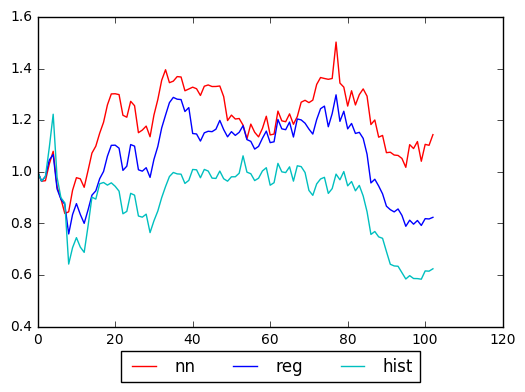

In [20]:
sharpe, md, cum = backtest(21*3, factor, ret, 21, rf)
#sum(rf[ ( 21 * (2- 1) ) : ( 21 * 2 - 1) ])

In [39]:
sharpe

(rf    0.180372
 dtype: float64, rf   -0.043307
 dtype: float64, rf    0.079433
 dtype: float64, rf   -0.06422
 dtype: float64)

In [40]:
md

(0.24484665205775691,
 0.39209484506567371,
 0.35896120035104045,
 0.52211895379176299)

This part is to say the overall market condition, the plot is for SPY. Because I find all the three strategies (reg, huber, uniformly buy and hold) have the similar trend, thus we want to see whether the market have the similar trend, which is true. That means all the strategies are probabily driven by the market movement (this is for stock dataset instead of for ETF dataset).

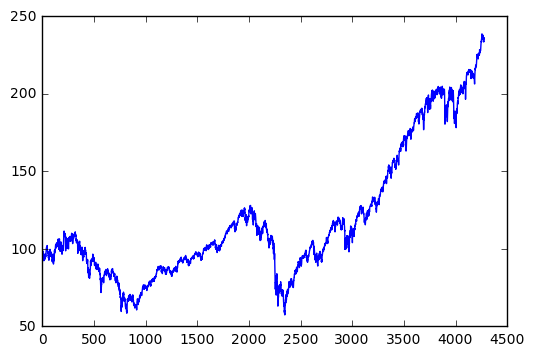

In [240]:
# start_date = datetime.datetime(1998, 5, 1)
# end_date = datetime.datetime(2017, 3, 31)
# ts = web.DataReader("SPY", "yahoo", start_date, end_date)
# ts.reset_index(inplace=True)
# ts.rename(columns = {'Date': 'DATE'}, inplace=True)
# spy = pd.DataFrame(index=ts.index)
# #datetime.datetime.fromtimestamp(int(ts['DATE'][0])).strftime("%Y-%m-%d")
# spy['DATE'] = ts['DATE'].map(lambda x : x.strftime("%Y-%m-%d"))
# spy['spy'] = ts['Adj Close']
# spy = pd.merge(spy, time, on = 'DATE')

# plt.plot(spy['spy'])
# plt.show()

This part is for lasso and ridge

In [11]:
def lasso_loss(ret, factor, alpha, para, n_sample, inter):
    return ((1 * (np.linalg.norm((ret - np.dot(factor, para) - inter), ord = 2))/(2*n_sample) 
            + alpha *np.linalg.norm(para, ord = 1) ), (np.linalg.norm((ret - np.dot(factor, para) - inter), ord = 2))/(2*n_sample),
           alpha *np.linalg.norm(para, ord = 1))

In [12]:
def validation(ret, factor):
    alpha_ = [ 0.00000001, 0.0000001,100, 1, 0.1, 0.01, 0.001, 0.0001,
              0.000000001, 0.0000003, 0.0000006, 0.0000009,
             0.00000003, 0.00000006, 0.00000009, 0.000000003, 
               0.000000006, 0.000000009, 0.0000000001, 0.00000000001, 0]
#     alpha_ = [0, 0.1, 100, 0.00001]
    #alpha_ = [0]
    achosen = alpha_[0]
    n = len(ret)
    training_index = int(n * 0.8)
    training_ret = ret[:training_index]
    #print(training_index)
    test_ret = ret[training_index:]
    training_factor = factor[:training_index]
    test_factor = factor[training_index:]
    n_sample = len(test_ret)
    clf = linear_model.Lasso(alpha=alpha_[0])
    clf.fit(training_factor, training_ret)
    para = clf.coef_
    inter = clf.intercept_
    minloss = lasso_loss(test_ret, test_factor, alpha_[0], para, n_sample, inter)
    #print(alpha_[0])
    #print(minloss)
    for i in range(1, len(alpha_)):
        clf = linear_model.Lasso(alpha=alpha_[i], max_iter=1000)
        clf.fit(training_factor, training_ret)
        #print(alpha_[i])
        paratem = clf.coef_
        inter = clf.intercept_
        #print((paratem, inter))
        #loss = lasso_loss(test_ret, test_factor, alpha_[i], paratem, n_sample, inter)
        loss = lasso_loss(test_ret, test_factor, alpha_[i], paratem, n_sample, inter)
        #print(loss)
        if(loss < minloss):
            minloss = loss
            achosen = alpha_[i]
    print(achosen)
    return achosen

In [13]:
def lasso(ret, factor, horizon, num):
    factor = factor.ix[1:]
    ret = ret[:-1]
    del factor['date']
    del ret['date']
    new_factor = pca(factor, num)
    norm_factor = normalize(new_factor)
    fitted = pd.DataFrame(index=ret.index)
    #norm_factor['one'] = np.ones(len(norm_factor))
    residual = []
    B = []
    inter = []
    for i in ret.columns:
        alpha_chosen = validation(ret[i], norm_factor)
        clf = linear_model.Lasso(alpha=alpha_chosen, max_iter=1000)
        clf.fit(norm_factor, ret[i])
        para = clf.coef_
        B.append(para)
        inter.append(clf.intercept_)
        #print(para)
        fitted[i] = np.dot(norm_factor, para)
        #print(fitted[i])
        resi = ret[i] - fitted[i] - clf.intercept_
        residual.append(np.var(resi))
    intercept = np.array(inter)
    mean = np.mean(fitted) + intercept
    B = np.matrix(B)
    #print(mean[0])
    cov_factor = np.cov(norm_factor, rowvar=0)
    allresidual = np.array(residual)
    cov_res = np.diag(allresidual)
    #print(cov_res)
    cov = np.dot(np.dot(B, cov_factor), np.transpose(B)) + cov_res
    return projection(estimate(mean, cov),horizon)

In [14]:
def ridge_loss(ret, factor, alpha, para, n_sample, inter):
    return ((1 * (np.linalg.norm((ret - np.dot(factor, para) - inter), ord = 2))
            + alpha *np.linalg.norm(para, ord = 2) ), np.linalg.norm((ret - np.dot(factor, para) - inter), ord = 2),
                                       alpha *np.linalg.norm(para, ord = 2))

In [15]:
def validation_ridge(ret, factor):
    alpha_ = [ 1000, 0.00001, 0]
    #alpha_ = [0]
    achosen = alpha_[0]
    n = len(ret)
    training_index = int(n * 0.8)
    training_ret = ret[:training_index]
    #print(training_index)
    test_ret = ret[training_index:]
    training_factor = factor[:training_index]
    test_factor = factor[training_index:]
    n_sample = len(test_ret)
    clf = linear_model.Ridge(alpha=alpha_[0])
    clf.fit(training_factor, training_ret)
    para = clf.coef_
    inter = clf.intercept_
    minloss = ridge_loss(test_ret, test_factor, alpha_[0], para, n_sample, inter)
    #print(alpha_[0])
    #print(minloss)
    for i in range(1, len(alpha_)):
        #print(alpha_[i])
        clf = linear_model.Ridge(alpha=alpha_[i], max_iter=1000)
        clf.fit(training_factor, training_ret)
        paratem = clf.coef_
        inter = clf.intercept_
        loss = ridge_loss(test_ret, test_factor, alpha_[i], paratem, n_sample, inter)
        #print(loss)
        #print((paratem, clf.intercept_))
        if(loss < minloss):
            minloss = loss
            achosen = alpha_[i]
    print(achosen)
    return achosen

In [16]:
def ridge(ret, factor, horizon, num):
    factor = factor.ix[1:]
    ret = ret[:-1]
    del factor['date']
    del ret['date']
    new_factor = pca(factor, num)
    norm_factor = normalize(new_factor)
    fitted = pd.DataFrame(index=ret.index)
    #norm_factor['one'] = np.ones(len(norm_factor))
    residual = []
    B = []
    inter = []
    for i in ret.columns:
        alpha_chosen = validation_ridge(ret[i], norm_factor)
        clf = linear_model.Ridge(alpha=alpha_chosen, max_iter=1000)
        clf.fit(norm_factor, ret[i])
        para = clf.coef_
        B.append(para)
        inter.append(clf.intercept_)
        #print(para)
        fitted[i] = np.dot(norm_factor, para)
        #print(fitted[i])
        resi = ret[i] - fitted[i] - clf.intercept_
        residual.append(np.var(resi))
    intercept = np.array(inter)
    mean = np.mean(fitted) + intercept
    B = np.matrix(B)
    #print(mean[0])
    cov_factor = np.cov(norm_factor, rowvar=0)
    allresidual = np.array(residual)
    cov_res = np.diag(allresidual)
    #print(cov_res)
    cov = np.dot(np.dot(B, cov_factor), np.transpose(B)) + cov_res
    return projection(estimate(mean, cov),horizon)

In [17]:
factor = pd.read_csv('data.txt', sep='\t')
ret = pd.read_csv('ret_etf.txt', sep='\t')

In [21]:
time = pd.DataFrame(index = ret.index)
time['DATE'] = ret['DATE']
factor = pd.merge(time, factor, on = 'DATE')
time = pd.DataFrame(index = factor.index)
time['DATE'] = factor['DATE']
ret = pd.merge(ret, time, on = 'DATE')
factor['date'] = factor['DATE'].map(lambda x : std(x))
ret['date'] = ret['DATE'].map(lambda x : std(x))
del factor['DATE']
del ret['DATE']
rf = pd.DataFrame(index = ret.index)
rf['rf'] = ret['rf']
del ret['rf']
try_factor = factor[factor['date'] <= datetime.datetime(2014, 6, 2)]
try_ret = ret[ret['date'] <= datetime.datetime(2014, 6, 2)]

In [29]:
trylasso = lasso(try_ret, try_factor, 21, 3)
#print(trylasso.mean, trylasso.cov)

[ 0.84518406  0.13036573  0.01643647]
0
100
100
0


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:26: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:16: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


100
100
0
0
0
0
0
0
0
100
100
100
100
0
100
0
100
0
3e-09
100
100
100
100
0.0001
100


In [35]:
tryridge = ridge(try_ret, try_factor, 21, 3)
#print(tryridge.mean, tryridge.cov)

[ 0.84518406  0.13036573  0.01643647]
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
